# Produce synthetic discrete gaussian data

In [2]:
import sys
sys.path.append("../src/")

import numpy as np

import matplotlib.pyplot as plt

from mask import simulate_mask
from plotting import plot_profile, plot_hmap
from splitting import train_val_split

from dgd_data_generator import (
    simulate_float_from_named_basis,
    simulate_dgd
)

%matplotlib inline

In [2]:
SEED = 42

# Location where data matrix and masks will be stored.
PATH_TO_DATA = "/Users/sela/Desktop/recsys/data/gd_data/100p_verify_gdl"

# To truncate profiles at empirical dropout times. The file contains a probbaility 
# vector where each entry of the vector holds a  probability that the female will never be 
# screened again.
PATH_TO_DROPOUT = '/Users/sela/phd/data/real/Pdropout_2Krandom.npy'

# Synthesize complete profiles

In [3]:
# MIKAL
# Can you please fill in fixed values you find appropriate for:
# * N: The number of females in the dataset. Maybe the same size as Jerome data?
# Answer: I suggest we use N=38000 as this is pretty close to the 38001 of Jerome data.
# * T: Resolution of the temporal axis (can stick with 321).
# Answer: I agree, T in Jerome data is 321
# * K: Continue to use rank 5?
# Answer: I will primarily be using K = 5 in my master's yes.

M = simulate_float_from_named_basis(
    basis_name='simple_peaks', 
    N=10, 
    T=321, 
    K=5, 
    domain=[1, 4], 
    random_state=SEED
)

# MIKAL
# * What parameters have you previously used?
# Answer:
# I've used np.arange(1,5) as these produce the integer values 1,2,3, and 4. 
# I've used theta = 2.5 as this produces datasets with just the right amount of
# noise. I will continue to use theta = 2.5 and np.arange(1,5) as the primary
# variable choices in my master's. 

D = simulate_integer_from_float(
    M, 
    domain_z=np.arange(1, 5),
    theta=2.5
    random_state=SEED
)

# Sparsening

In [4]:
# MIKAL:
# * If you have an idea on which param configs we should use to derive a mask with the target 
#   densities (see dicussion on Slack), please fill then in (e.g.) mask_level etc.
# Answer:
# Knowing a priori which level produces a given sparsity level is impossible 
# as this is affected both by M and by screening_proba. For sparsities 
# 100%, 80%, 50%, 20%, 10%, 5% and 3% we must find corresponding level values
# using trial and error.

M = simulate_mask(
    D,
    screening_proba=np.array([0.05, 0.15, 0.40, 0.60, 0.20])
    memory_length=10,
    level=1000 #0.6
    path_dropout=PATH_TO_DROPOUT,
    random_state=SEED
)

In [5]:
X = D * M

# Training and validation sets

In [6]:
# MIKAL:
# * We start out on 1 year predictions and then increase in analyses?
# Answer: 
# I think this is a good idea yes. Anything smaller is too optimistic and 
# anything larger is bound to decrease model performance.

prediction_window = 4

O_val, O_train = train_val_split(X, prediction_window, method='last_observed', seed=SEED)

X_val = X * O_val
X_train = X * O_train

# Inspect

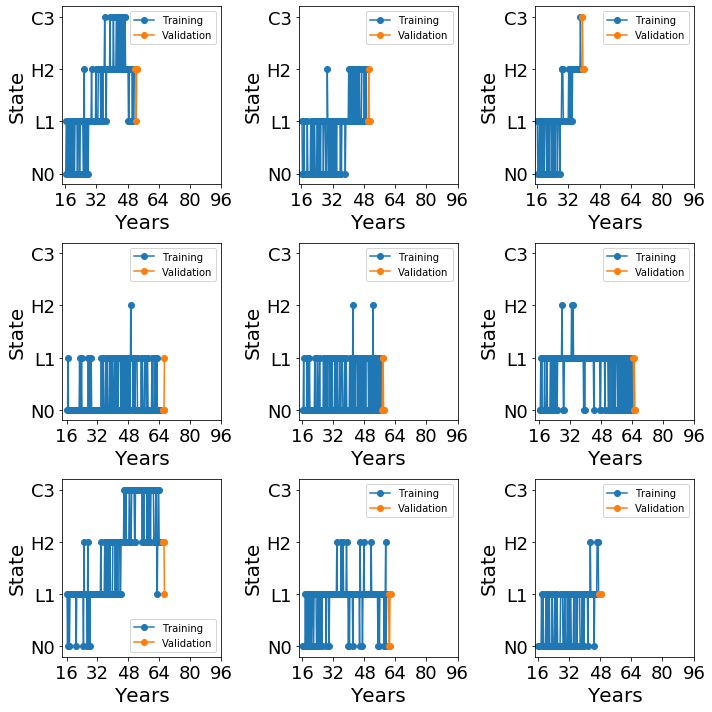

In [7]:
_, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for num, axis in enumerate(axes.ravel()):
    
    # Add plot to figure.
    plot_profile(X_train[num], axis, show=False, label='Training')
    plot_profile(X_val[num], axis, show=False, label='Validation')
    
    axis.legend()

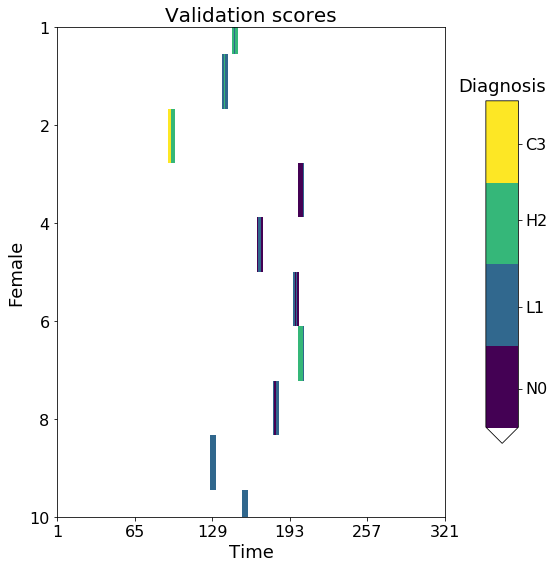

States: [1. 2. 3. 4.]
Counts: [12 24 12  2]
Number of all-zero profiles: 0


In [8]:
fig = plt.figure(figsize=(8, 8))
plt.title("Validation scores", fontsize=20)
plot_hmap(fig, X_val)

vals, cnts = np.unique(X_val[X_val != 0], return_counts=True)
print('States:', vals)
print('Counts:', cnts)

# Sanity check.
print('Number of all-zero profiles:', len(np.squeeze(np.where(np.sum(X_val, axis=1) == 0))))

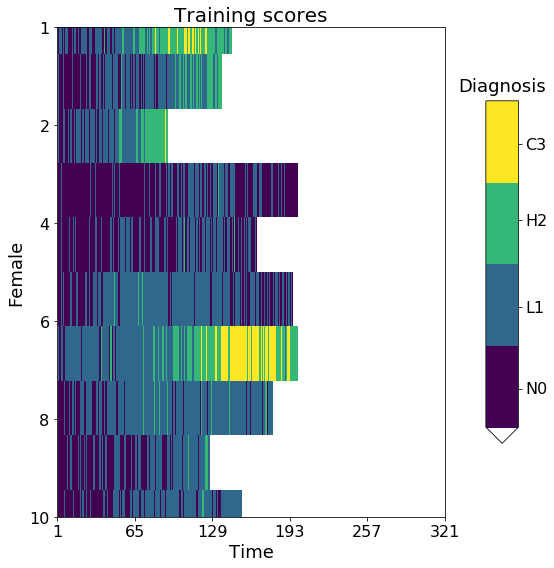

States: [1. 2. 3. 4.]
Counts: [527 810 180  60]
Number of all-zero profiles: 0


In [9]:
fig = plt.figure(figsize=(8, 8))
plt.title("Training scores", fontsize=20)
plot_hmap(fig, X_train)

vals, cnts = np.unique(X_train[X_train != 0], return_counts=True)
print('States:', vals)
print('Counts:', cnts)

# Sanity check.
print('Number of all-zero profiles:', len(np.squeeze(np.where(np.sum(X_train, axis=1) == 0))))

# Save data to disk

In [10]:
np.save(f'{PATH_TO_DATA}/X.npy', X)
np.save(f'{PATH_TO_DATA}/O_val.npy', O_val)
np.save(f'{PATH_TO_DATA}/O_train.npy', O_train)